In [99]:
from analysis_ import AnalysisTargets, ClusterFinancials
from data import FinancialsData
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

In [103]:
cf = ClusterFinancials()
gmm = list(cf.gmm.cluster())

# gmm_cov = cf.gmm.cluster_cov()
# gmm_weights = cf.gmm.weights()

# print(gmm_weights)

        DilutedEPS       NormalizedEBITDA        TotalRevenue        \
              mean count             mean count          mean count   
cluster                                                               
0.0      10.410019    53     1.224931e+09    53  6.811841e+09    53   
1.0      -6.410000     1    -1.471149e+09     1  2.711100e+07     1   
2.0       7.720333    10     2.143119e+10    10  1.255643e+11    10   
3.0       2.948750    32     4.618939e+09    32  2.284869e+10    32   

            MarketCap       PriceYoY2021       PriceYoY2022        \
                 mean count         mean count         mean count   
cluster                                                             
0.0      2.399802e+10    53    15.703526    53    -9.164346    53   
1.0      1.423400e+10     1   284.346962     1   -81.919585     1   
2.0      1.874568e+11    10    45.955547    10   -30.224197    10   
3.0      5.322412e+10    32    38.865698    32   -14.934946    32   

        RevenueYoY

Text(0.5, 0, '')

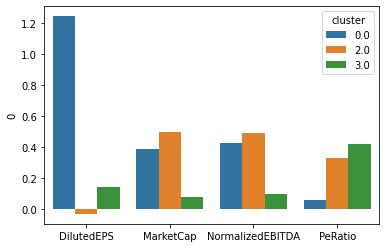

In [78]:
s_df = pd.read_csv('symbol_fundamentals.csv').set_index('symbol')
#print(s_df)


# Specify the file path for the CSV file
csv_file_path = 'stock_clusters.csv'

#print(gmm)
cluster_count = max(set([i[1] for i in gmm]))
gmm_dict = dict()
for i in range(0, cluster_count + 1):
    gmm_dict[i] = []    
for i in gmm:
    gmm_dict[i[1]].append(i[0])
for k in gmm_dict:
    df = pd.DataFrame()
    at = AnalysisTargets()
    for symbol in gmm_dict[k]:
        df = pd.concat([df, at.create_target_dataset(symbol)])
        s_df.loc[symbol,'cluster'] = k
    #print(f"Cluster {k+1}:\n{gmm_dict[k]}")
    #print(df.describe())
    

s_df = s_df.drop(['Description', 'Sector', 'Industry', 'asOfDate'], axis = 1).groupby('cluster').agg(['mean', 'count'])
print(s_df)
s_df = s_df[['DilutedEPS', 'MarketCap', 'NormalizedEBITDA', 'PeRatio']]
#s_df = s_df[s_df['cluster']
#print(s_df)
# Calculate the mean and standard deviation for each column
mean = np.mean(s_df, axis=0)

print(s_df)
std = np.std(s_df, axis=0)

# Standardize each column using the calculated mean and standard deviation
df_st = (s_df - mean) / std

print(df_st.columns)
df_st = df_st[df_st.index != 1]

#print(df_st.unstack().reset_index())
ax = sns.barplot(data=df_st.unstack().reset_index(), x='level_0', y=0, hue='cluster', ci = None)
ax.set_xlabel("")

# csv_file_path = 'stock_clusters.csv'

# data_list = []

# for cluster, symbols in gmm_dict.items():
#     for symbol in symbols:
#         cluster_list = ([symbol, cluster])
#         data_list.append(cluster_list)
        
# print(data_list)
# df_cluster = pd.DataFrame(data_list, columns = ['symbol', 'cluster'])
# df_cluster

# df_cluster.to_csv(csv_file_path, index=False)

    
#sns.barplot(data=s_df, x="cluster", y="body_mass", hue="sex")


## T-SNE (Base Model)

0.18366663


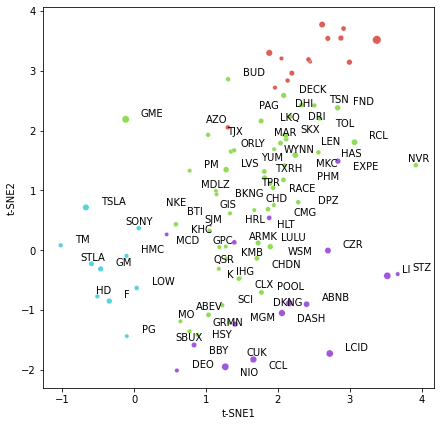

In [104]:
from adjustText import adjust_text
from sklearn.metrics import silhouette_score

fd = FinancialsData()
results = cf.tsne.reduce(perplexity=30, n_iter=5000)
df_1 = pd.DataFrame(columns=["t-SNE1", "t-SNE2", "AvgVolatility", "Sector", "Cluster", "Industry"])
df_1["t-SNE1"] = results[:, 0]
df_1["t-SNE2"] = results[:, 1]
#print(df_1['t-SNE1'])
#df["MarketCap"] = fd.get_yfinance_data()["DilutedEPS"]
df_1["Sector"] = fd.get_yfinance_data()["Sector"]
df_1["Industry"] = fd.get_yfinance_data()["Sector"]
df_1["Symbol"] = fd.get_yfinance_data().symbol

#print(cf.gmm.ideal_cluster_num())
#print(list(cf.gmm.cluster(n_components=4)))


cluster_assignments = [i[1] for i in cf.gmm.cluster(n_components=4)]
for k, v in cf.gmm.cluster(n_components=4):
     df_1.loc[(df_1["Symbol"] == k), "Cluster"] = v
for i in df_1["Symbol"]:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_1.loc[(df_1["Symbol"] == i), "AvgVolatility"] = mean
    
silhouette_avg = silhouette_score(results, df_1['Cluster'])
print(silhouette_avg)

    
    
num_colors = len(set(df_1["Cluster"]))
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_1,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)

df_sc = df_1[df_1['Cluster'] != 0]

texts = []
for stock_index in range(len(df_sc.index)):
     text = plt.text(df_sc.iloc[stock_index]['t-SNE1'] + 0.2, df_sc.iloc[stock_index]['t-SNE2'], df_sc.iloc[stock_index]['Symbol'], 
            horizontalalignment='left', size='medium', color='black', weight='light')
     texts.append(text)
adjust_text(texts)
            
plt.show()

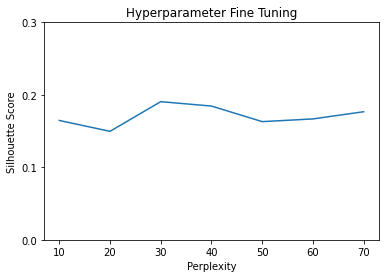

In [138]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Define the range of values for perplexity and n_iterations
perplexity_values = [10, 20, 30, 40, 50, 60, 70]
n_iterations_values = [1000, 3000, 5000]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Perplexity", "Silhouette Score"])

results_list = []

# Iterate over different perplexity and n_iterations values
for perplexity in perplexity_values:
        # Perform t-SNE embedding with current hyperparameter values
        #results = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iterations).fit_transform(df_1[["t-SNE1", "t-SNE2"]])
        results = cf.tsne.reduce(perplexity=perplexity, n_iter=5000)
        # Calculate silhouette score using the resulting embeddings and cluster assignments
        silhouette_avg = silhouette_score(results, df_1['Cluster'])

        # Store the results in the DataFrame
        results_list.append({"Perplexity": perplexity, "Silhouette Score": silhouette_avg})

results_df = pd.DataFrame(results_list)
#print(results_df)
fig, ax = plt.subplots()
#ax = fig.add_subplot(111, projection = '3d')
X, Y = results_df['Perplexity'], results_df['Silhouette Score']
#print(X)
#Z = np.array(results_df['Silhouette Score'])
sns.lineplot(data = results_df, x = 'Perplexity', y = 'Silhouette Score')
ax.set_title("Hyperparameter Fine Tuning")
ax.set_xlabel("Perplexity")
ax.set_ylabel("Silhouette Score")
ax.set_yticks([0.0, 0.10, 0.20, 0.30])
# ax.set_zlabel("Silhouette Score")
#sns.lineplot(data = results_df, x= 'Perplexity', y = 'Silhouette Score', ax=ax)
plt.show()
# Print the results


In [116]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# # Iterate over different perplexity and n_iterations values
# for perplexity in perplexity_values:
#     for n_iterations in n_iterations_values:
#         # Perform t-SNE embedding with current hyperparameter values
#         results = cf.tsne.reduce(perplexity=perplexity, n_iter= n_iterations)

#         # Create scatter plot
       
#         sns.lineplot(x=results[:, 0], y=results[:, 1], hue=df_1["Cluster"], ax = ax)
#         ax.set_.title(f"Perplexity: {perplexity}, n_iterations: {n_iterations}")

# plt_show



# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# # Iterate over different perplexity and n_iterations values
# for i, perplexity in enumerate(perplexity_values):
#     for j, n_iterations in enumerate(n_iterations_values):
#         # Perform t-SNE embedding with current hyperparameter values
#         results = cf.tsne.reduce(perplexity=perplexity, n_iter=n_iterations)

#         # Create line plot
#         ax = axes[i, j]
#         sns.lineplot(x=range(n_iterations), y=perplexity, ax=ax)
#         ax.set_title(f"Perplexity: {perplexity}, n_iterations: {n_iterations}")
#         ax.set_xlabel("Number of Iterations")
#         ax.set_ylabel("t-SNE Result")

# # Adjust spacing between subplots
# fig.tight_layout()

# # Show the plot
# plt.show()

In [107]:
pd.set_option('display.max_rows', None)
ideal_clusters = cf.gmm.cluster_probabilities(n_components = 4)
ideal_clusters
# cf.gmm.ideal_cluster_num()

,Component0,Component1,Component2,Component3
TSLA,0.000,0.000,1.0,0.000
PG,0.000,0.000,1.0,0.000
HD,0.000,0.000,1.0,0.000
MCD,0.000,0.000,0.0,1.000
TM,0.000,0.000,1.0,0.000
NKE,0.000,1.000,0.0,0.000
PM,0.000,1.000,0.0,0.000
LOW,0.000,0.000,1.0,0.000
SONY,0.000,0.000,1.0,0.000
SBUX,0.000,0.999,0.0,0.001


#why GMM
GMM is very useful here. 

Compared to K-means it can capture more complicated normal distributions of the data, whereas K-means
largely targets spherical shapes in the data.

We also expect clusters to have varying densities and sizes. For example, we expect most stocks to be associated with neutral performance, and some stocks associated with positive and negative performance. GMM tends to perform quite well in these conditions, whereas K-means and DBSCAN will typically struggle here. 

Lastly, it makes intuitive sense to assign soft-clustering for our purposes. If the latent variables are associated with investor sentiment/performance then we expect many stocks, probability wise, to fall into multiple different clusters.



#We used BIC to determine the ideal number of clusters. This is an effective feature evaluation method because it can control for overfitting while maximizing log-likelihood. BIC determined that the ideal number of clusters for GMM is 4 clusters.

In [52]:
cf_with_sentiment = ClusterFinancials(sentiment=True)



print(cf_with_sentiment.gmm.ideal_cluster_num())
cf_with_sentiment.gmm.cluster_probabilities(n_components=4)


[-4706.902817986695, -5050.670062322293, -4529.447984782173, -3865.9960112542863, -3329.1538741874674, -2876.027037038227, -2576.0180795811357, -2198.239571880147, -1617.2982464201286, -739.9665278796538]
[2, -5050.670062322293]


,Component0,Component1,Component2,Component3
TSLA,0.0,0.0,1.0,0.0
PG,0.0,0.0,1.0,0.0
HD,0.0,0.0,1.0,0.0
MCD,0.0,0.0,0.0,1.0
TM,0.0,0.0,1.0,0.0
...,...,...,...,...
SKX,0.0,1.0,0.0,0.0
TOL,0.0,1.0,0.0,0.0
GME,0.0,1.0,0.0,0.0
WSM,0.0,1.0,0.0,0.0


## T-SNE with Cluster Sentiments

0.02061258


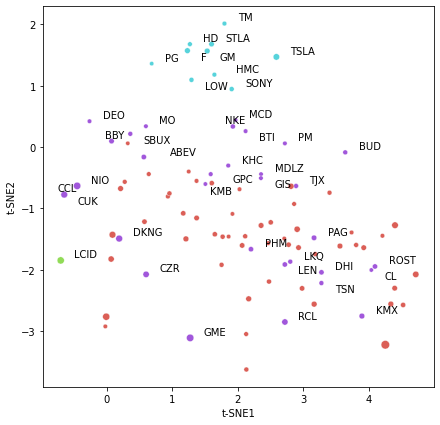

In [13]:
cf_with_sentiment = ClusterFinancials(sentiment=True)
results = cf_with_sentiment.tsne.reduce(perplexity=30, n_iter=5000)
df_1 = pd.DataFrame(columns=["t-SNE1", "t-SNE2", "AvgVolatility", "Sector", "Cluster", "Industry"])
df_1["t-SNE1"] = results[:, 0]
df_1["t-SNE2"] = results[:, 1]
df_1["Sector"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Industry"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Symbol"] = cf_with_sentiment.get_yfinance_data().symbol


cluster_assignments = [i[1] for i in cf_with_sentiment.gmm.cluster(n_components = 4)]
for k, v in cf_with_sentiment.gmm.cluster(n_components = 4):
    df_1.loc[(df_1["Symbol"] == k), "Cluster"] = v

for i in df_1["Symbol"]:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_1.loc[(df_1["Symbol"] == i), "AvgVolatility"] = mean
    
silhouette_avg = silhouette_score(results, df_1['Cluster'])
print(silhouette_avg)

num_colors = 4
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_1,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)

df_sc = df_1[df_1['Cluster'] != 0]

texts = []
for stock_index in range(len(df_sc.index)):
     text = plt.text(df_sc.iloc[stock_index]['t-SNE1'] + 0.2, df_sc.iloc[stock_index]['t-SNE2'], df_sc.iloc[stock_index]['Symbol'], 
            horizontalalignment='left', size='medium', color='black', weight='light')
     texts.append(text)
adjust_text(texts)

plt.show()


## UMAP (Base Model)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [10, 20, 30, 40, 50],
    'min_dist': [0.1, 0.2, 0.3, 0.4, 0.5]
}

reducer = umap.UMAP(random_state=42)

def umap_silhouette_scorer(estimator, X):
    embeddings = estimator.transform(X)
    labels = estimator.gmm.fit_predict(embeddings)
    return silhouette_score(embeddings, labels)


In [18]:
# Perform grid search
def grid_search(reducer = reducer, params = param_grid, scoring = umap_silhouette_scorer, obj = cf.umap):

    grid_search = GridSearchCV(reducer, params, scoring = scoring)
    grid_search.fit(obj.reduce())
    print(grid_search.best_estimator_)
    return grid_search.best_estimator_

best_reducer = grid_search()

UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


In [53]:
# Get the best UMAP model from grid search
best_reducer = grid_search()


# Perform UMAP dimensionality reduction
results_base = best_reducer.transform(cf.umap.reduce())

print(len(results_base[:,0]))

df_1["UMAP1"] = results_base[:, 0]
df_1["UMAP2"] = results_base[:, 1]

silhouette_avg = silhouette_score(results_base, df_1['Cluster'])
print(silhouette_avg)


UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})
96
-0.18533863


NameError: name 'best_reduce' is not defined

In [54]:
grid_search.best_params_

AttributeError: 'function' object has no attribute 'best_params_'

In [123]:
def cluster_assign(obj = cf.gmm, df = df_1):
    
    cluster_assignments = [i[1] for i in obj.cluster(n_components = 4)]
    for k, v in obj.cluster(n_components = 4):
        df.loc[(df_1["Symbol"] == k), "Cluster"] = v
    
    return df

df_1 = cluster_assign()


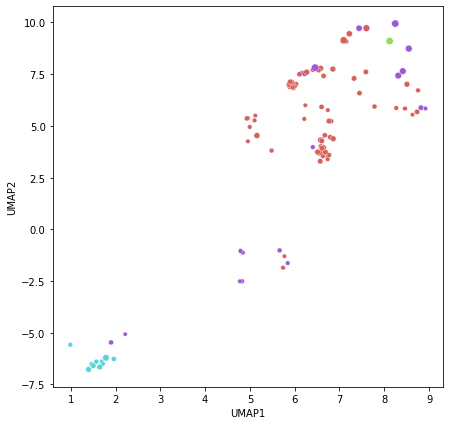

In [115]:
from sklearn.neighbors import Nearest Neighbors

#outliers - ford, toyota, stla, nio, mdlz, len

# mean = np.mean(df_1['UMAP1'])
# std = np.std(df_1['UMAP1'])

# #outliers = df_1[(df_1['UMAP1'] > 0.9*std*mean) | (df_1['UMAP1'] < -0.9*std*mean)]

def outlier_detects(df = df1, k =5, outlier_thresh = 0.9):
    umap_coords = df[['UMAP1', 'UMAP2']].values
    neighbors_model = NearestNeighbors(n_neighbors=k)
    neighbors_model.fit(umap_coords)
    distances = neighbors_model.kneighbors(umap_coords)[0]
    
    max_distance = np.percentile()    
    

def plot_scatter(data = df1, num_colors = 4, outlier_df = outliers):

    plt.figure(figsize=(7, 7))
    sns.scatterplot(
        x="UMAP1",
        y="UMAP2",
        hue="Cluster",
        size="AvgVolatility",
        data=df_1,
        palette=sns.color_palette("hls", num_colors),
        legend=False,

    )

    for stock_index in range(len(outliers.index)):
         plt.text(outliers.iloc[stock_index]['UMAP1'] + 0.2, outliers.iloc[stock_index]['UMAP2'], outliers.iloc[stock_index]['Symbol'], 
                  horizontalalignment='left', size='medium', color='black', weight='semibold')
            
    plt.show()

## UMAP (Sentiment Model)


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

reducer = umap.UMAP(random_state=42)

# Perform grid search
#import pdb; pdb.set_trace()
grid_search_sent = GridSearchCV(reducer, param_grid, scoring = umap_silhouette_scorer)
grid_search_sent.fit(cf_with_sentiment.umap.reduce())
print("Best Silhouette Score:", grid_search_sent.best_params_)

Best Silhouette Score: {'min_dist': 0.1, 'n_neighbors': 10}


In [47]:
# Get the best UMAP model from grid search
best_reducer_sent = grid_search_sent.best_estimator_


# Perform UMAP dimensionality reduction
results_sent = best_reducer_sent.transform(cf_with_sentiment.umap.reduce())


df_2 = pd.DataFrame()
df_2.index = df_1['Symbol']
df_2["UMAP1"] = results_sent[:, 0]
df_2["UMAP2"] = results_sent[:, 1]

#print(df_1)
for i in df_2.index:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_2.loc[i, "AvgVolatility"] = mean

df_2.reset_index(inplace = True)
df_2.rename({'index': 'Symbol'}, inplace=True)
#print(df_2)

   Symbol     UMAP1     UMAP2  AvgVolatility
0    TSLA -4.456754  0.571961       1.484948
1      PG -3.534466  0.457819       0.444335
2      HD -3.489391  0.134065       0.620765
3     MCD -3.363161  0.119767       0.419712
4      TM -3.323002  0.011634       0.611028
5     NKE -3.312515  0.078561       0.752377
6      PM -3.394485  0.276216       0.505376
7     LOW -3.457175  0.177024       0.710447
8    SONY -3.459296  0.142790       0.722501
9    SBUX -3.474666  0.119719       0.650127
10    BUD -3.300685  0.134225       0.666948
11   MDLZ -3.536946  0.336942       0.460954
12    DEO -4.229451  0.793632       0.517019
13   BKNG -3.449530  0.095854       0.914889
14    TJX -3.208825  0.316860       0.701126
15     MO -3.622809  0.259978       0.512094
16    BTI -3.407176 -0.035623       0.535317
17   ABNB -4.255591  0.816506       1.306348
18     CL -3.007850  0.430041       0.435776
19    CMG -3.433136  0.345010       0.745682
20   ORLY -3.449961  0.297012       0.584303
21    HSY 

In [48]:
num_colors = 4
cluster_assignments = [i[1] for i in cf_with_sentiment.gmm.cluster(n_components = 4)]
for k, v in cf_with_sentiment.gmm.cluster(n_components = 4):
    df_2.loc[(df_2["Symbol"] == k), "Cluster"] = v

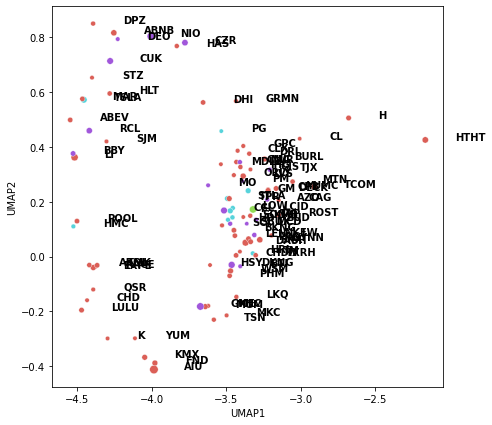

In [55]:
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_2,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)

for stock_index in range(len(df_2.index)):
     plt.text(df_2.iloc[stock_index]['UMAP1'] + 0.2, df_2.iloc[stock_index]['UMAP2'], df_2.iloc[stock_index]['Symbol'], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')
        
plt.show()

#HTHT, H, CL


In [56]:
print(grid_search_sent.best_params_)

{'min_dist': 0.1, 'n_neighbors': 10}


In [ ]:
cf_with_sentiment = ClusterFinancials(sentiment=True)
results = cf_with_sentiment.dbscan.reduce(perplexity=55, n_iter=5000)
df_1 = pd.DataFrame(columns=["t-SNE1", "t-SNE2", "AvgVolatility", "Sector", "Cluster", "Industry"])
df_1["t-SNE1"] = results[:, 0]
df_1["t-SNE2"] = results[:, 1]
df_1["Sector"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Industry"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Symbol"] = cf_with_sentiment.get_yfinance_data().symbol


cluster_assignments = [i[1] for i in cf_with_sentiment.gmm.cluster(n_components = 4)]
for k, v in cf_with_sentiment.gmm.cluster(n_components = 4):
    df_1.loc[(df_1["Symbol"] == k), "Cluster"] = v

for i in df_1["Symbol"]:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_1.loc[(df_1["Symbol"] == i), "AvgVolatility"] = mean
    
silhouette_avg = silhouette_score(results, df_1['Cluster'])
print(silhouette_avg)

num_colors = 4
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_1,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)

df_sc = df_1[df_1['Cluster'] != 0]

texts = []
for stock_index in range(len(df_sc.index)):
     text = plt.text(df_sc.iloc[stock_index]['t-SNE1'] + 0.2, df_sc.iloc[stock_index]['t-SNE2'], df_sc.iloc[stock_index]['Symbol'], 
            horizontalalignment='left', size='medium', color='black', weight='light')
     texts.append(text)
adjust_text(texts)

plt.show()